# Stanford - 96 codes - Jupyter example
title             : Stanford - 96 codes - Jupyer example.nbpy [filename]
description       : Multi file - Stanford Setup
author            : Bjorn Harink                              [Original author(s) of this file]
credits           : Kurt Thorn, Huy Nguyen                    [Contributors to this file]
date              : 20170220                                  [Initial date yyyymmdd]
version update    : 20170220                                  [Last version update yyyymmdd]
version           : v0.1
usage             : This is an example file for the Bead Analysis module.
notes             : Multiple file code set for Stanford setup - Jupyter Notebook
python_version    : 2.7

# Import modules and bead analysis tools

In [1]:
# [Future imports]
# "print" function compatibility between Python 2.x and 3.x
from __future__ import print_function
# Use Python 3.x "/" for division in Pyhton 2.x
from __future__ import division

# [Modules]
# General Python
import sys
sys.path.append('../')  # Or wherever your Bead Analysis module folder is
import random
# Data structures
import numpy as np
import pandas as pd
# Image Processing
from scipy import ndimage as ndi # Imaging
from sklearn.mixture import GaussianMixture
# Project
import bead_analysis as ba

# Image display/notebook settings
import matplotlib as mpl
%matplotlib notebook
mpl.rcParams['savefig.dpi'] = 187 # set to your display DPI
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Copyright 2016 - The Encoded Beads Project - ThornLab@UCSF and FordyceLab@Stanford


# Global Settings

In [2]:
# Reference image location
REF_FILES = {"Dy" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Dy_solo_20160915_3\Dy_solo_20160915_3_MMStack_Pos0.ome.tif",
             "Sm" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Sm_solo_20160915_1\Sm_solo_20160915_1_MMStack_Pos0.ome.tif",
             "Tm" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Tm_1_2_solo_20160915_4\Tm_1_2_solo_20160915_4_MMStack_Pos0.ome.tif",
             "Eu" : r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\Eu_solo_20160915_3\Eu_solo_20160915_3_MMStack_Pos0.ome.tif"}

TRP_FILE = r"Z:\Bjorn\[Stanford]\Ref Spectra Stanford\20170124_Blank_W_1\20170124_Blank_W_1_MMStack_Pos0.ome.tif"

# Target file location
TARGET_FILE = r"Z:\Code Sets\20160226_DySmTm_48Codes.csv"

# General Region or interest
# slice(Y1, Y2) and slice(X1, X2) Y and X are reversed in array since rows (Y) go first and columns go second (X). Pandas includes stop element!
CROPx = slice(250, 750)
CROPy = slice(250, 750)


#########################
###   Targets/Codes   ###
"""[NOTES - Target File]
The target file contains the code ratios and are stored 
in a csv file with makeup [CeTb, Dy, Sm, Tm], e.g.:
>>> target
array([[ 0.20061,  0.08155,  0.     ,  0.65606],
       [ 0.     ,  0.08155,  0.10822,  0.     ],
       [ 0.     ,  0.08155,  0.10822,  0.19141],
       ...
"""

target = np.genfromtxt(TARGET_FILE, delimiter=',')
target = target[:, 1:4]  # Target set to Dy, Sm, Tm (no CeTb)

# Bead search and filter parameters
bead_objects = ba.FindBeads(min_r=4, max_r=8, min_dist=7, param_1=10, param_2=7, annulus_width=3, enlarge = 1)
reference_std_factor_low = 1.5
reference_std_factor_high = 2
back_std_factor = 3

# ICP settings
icp=ba.ICP(matrix_method='std', max_iter=100, tol=1e-4, outlier_pct=0.01, train=False)

# GMM settings
gmix = ba.Classify(target, tol=1e-5, min_covar=1e-7, sigma=1e-5, train=False)

# Reference Spectra

Spectrum Bkg: slice(339, 445, None), slice(420, 508, None)
Spectrum: Eu
Number of unique segments found: 277
Spectrum: Tm
Number of unique segments found: 277
Spectrum: Sm
Number of unique segments found: 391
Spectrum: Dy
Number of unique segments found: 251
Spectrum: Tp
Number of unique segments found: 286


<IPython.core.display.Javascript object>


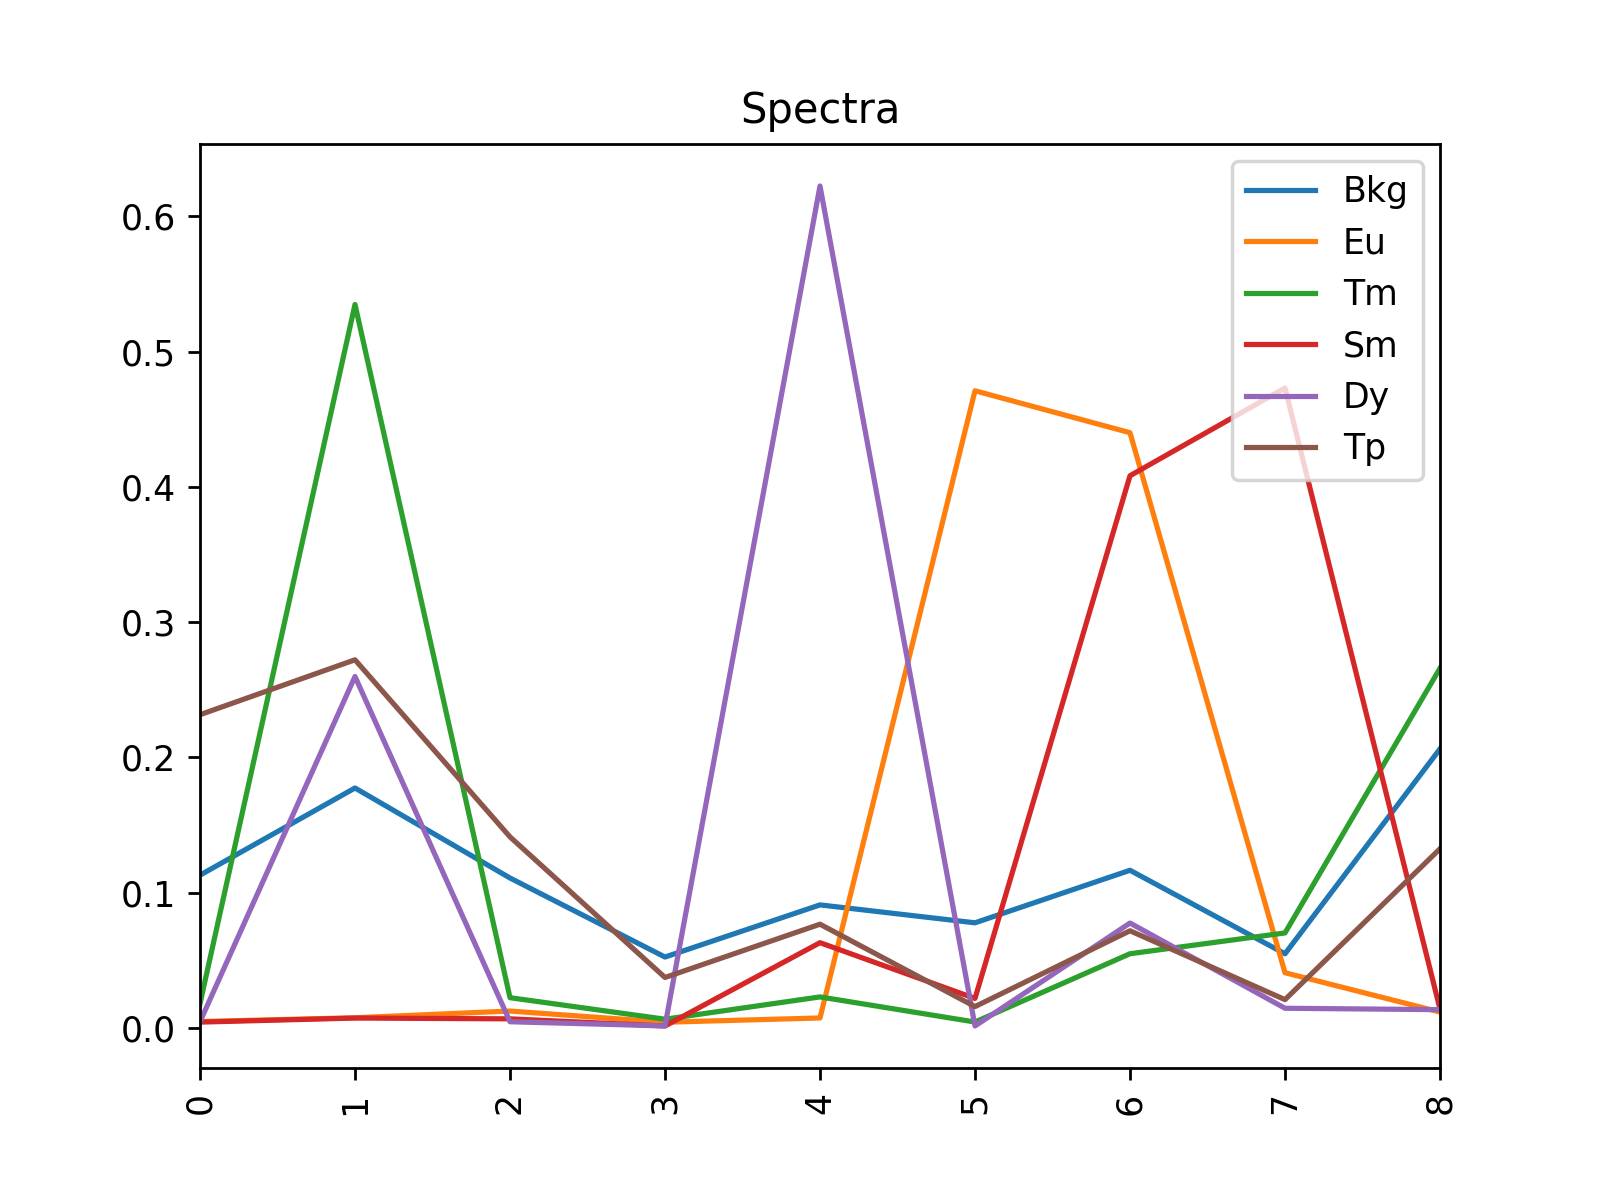

In [4]:
# Background image set file location
BACK_FILE = r"Z:\Bjorn\[Stanford]\20161118 48B20160929\20161118_48B_20160929_1to48b_2\20161118_48B_20160929_1to48b_2_MMStack_Pos0.ome.tif"

# Reference images ROI
CROPx_ref = slice(600, 1550)
CROPy_ref = slice(600, 1550)

# Background ROI
BACK_CROPx = slice(339, 445)
BACK_CROPy = slice(420, 508)

dark_noise = 99  # Camera dark noise
spec_object = ba.simp.ReferenceSpectra(files = REF_FILES, 
                                       object_channel = 'Brightfield', 
                                       channels = ['435','780'], 
                                       find_param = [14,16,10,6], 
                                       dark_noise = dark_noise, 
                                       crop_x = CROPx_ref, 
                                       crop_y = CROPy_ref)
spec_object.set_back(BACK_FILE, ['435','780'], BACK_CROPx, BACK_CROPy)
ref_data_object = spec_object.output

# Trp
name = "Tp"
print("Spectrum: %s" % name)
CROPx_ref_tp = slice(250, 750)
CROPy_ref_tp = slice(250, 750)
ref_objects_tp = ba.FindBeads(min_r=7, max_r=9, param_1=10, param_2=6)
ref_img_obj = ba.ImageSetRead(TRP_FILE)
ref_objects_tp.find(ref_img_obj['Brightfield',CROPy_ref_tp,CROPx_ref_tp])
channels = ref_img_obj['l-435':'l-780',CROPy_ref_tp,CROPx_ref_tp]
ref_data_tmp = spec_object.get_spectrum(dark_noise, channels, ref_objects_tp.labeled_mask)
ref_data_object.spec_add(name, data=ref_data_tmp)

ref_data_object.plot()

# Load image files and detect objects
Initiated bead_set data

In [5]:
# Bead image set file location
BEAD_IMAGE_FOLDER = r"Z:\Bjorn\[Stanford]\20170102 Pre"
BEAD_IMAGE_PATTERN = "20170102_48B_20161229_Preb_*"

bead_image_files = ba.ImageSetRead.scan_path(BEAD_IMAGE_FOLDER, BEAD_IMAGE_PATTERN)
bead_image_obj = ba.ImageSetRead(bead_image_files)
bead_image_set_bf = bead_image_obj[:,'Brightfield',CROPy,CROPx]
bead_image_set_ln = bead_image_obj[:,'l-435':'l-780',CROPy,CROPx]

bead_set = pd.DataFrame(columns=['img', 
                                 'lbl', 
                                 'dim_x', 
                                 'dim_y', 
                                 'dim_r',
                                 'bkg',
                                 'ref',
                                 'rat_dy',
                                 'rat_sm',
                                 'rat_tm'])

labels = []
labels_annulus = []
bead_no = 0
for idx in xrange(bead_image_obj.f_size):
    bead_objects.find(bead_image_set_bf[idx])
    if bead_objects.labeled_mask is None:
        continue
    labels.append(bead_objects.labeled_mask)
    labels_annulus.append(bead_objects.labeled_annulus_mask)
    circles_dim = np.array(bead_objects.circles_dim)
    for lbl in np.arange(1, len(np.unique(labels[idx]))):
        bead_set.loc[bead_no,('img', 'lbl', 'dim_x', 'dim_y', 'dim_r')] = \
            [idx, lbl, circles_dim[lbl-1, 0], circles_dim[lbl-1, 1], circles_dim[lbl-1, 2]]
        bead_no += 1

Number of unique segments found: 200
Number of unique segments found: 180
Number of unique segments found: 132
Number of unique segments found: 240
Number of unique segments found: 251
Number of unique segments found: 228
Number of unique segments found: 304
Number of unique segments found: 232
Number of unique segments found: 355
Number of unique segments found: 356
Number of unique segments found: 352
Number of unique segments found: 171
Number of unique segments found: 269
Number of unique segments found: 317
Number of unique segments found: 316
Number of unique segments found: 219
Number of unique segments found: 264


# Unmix and get Ratios

In [6]:
spec_unmix = ba.SpectralUnmixing(ref_data_object)
bead_no = 0
for lbls_idx, lbls in enumerate(labels):
    spec_unmix.unmix(bead_image_set_ln[lbls_idx])

    background = spec_unmix['Bkg']  # Device background
    reference = spec_unmix['Eu']  # Internal reference: Eu
    # Ratio images
    ratio_Dy = spec_unmix['Dy'] / reference
    ratio_Sm = spec_unmix['Sm'] / reference
    ratio_Tm = spec_unmix['Tm'] / reference
    # Get ratios from images
    idx = np.arange(1, len(np.unique(lbls)))
    ratio_data = np.empty((len(idx), target[0].size))
    ratio_data[:, 0] = ndi.labeled_comprehension(ratio_Dy, lbls, idx, np.median, float, -1)
    ratio_data[:, 1] = ndi.labeled_comprehension(ratio_Sm, lbls, idx, np.median, float, -1)
    ratio_data[:, 2] = ndi.labeled_comprehension(ratio_Tm, lbls, idx, np.median, float, -1)

    background_data = ndi.labeled_comprehension(background, lbls, idx, np.median, float, -1)
    reference_data = ndi.labeled_comprehension(reference, lbls, idx, np.median, float, -1)

    for lbl in np.arange(1, len(np.unique(lbls))):
        bead_set.loc[bead_no,('rat_dy', 'rat_sm', 'rat_tm', 'bkg', 'ref')] = \
            [ratio_data[lbl-1,0], ratio_data[lbl-1,1], ratio_data[lbl-1,2], background_data[lbl-1], reference_data[lbl-1]]
        bead_no += 1

In [7]:
bead_set

img  lbl dim_x dim_y dim_r      bkg      ref      rat_dy       rat_sm  \
0      0    1   351     6     6 -12492.8   101709    0.427143   0.00135897   
1      0    2    95     9     6    -8757   110743  0.00758383 -0.000755453   
2      0    3   109    12     8 -3831.89  80939.2  0.00705215  -0.00223597   
3      0    4   260    12     6 -19195.5   116220    0.908139    0.0020661   
4      0    5   372    15     7 -5034.62  92152.7    0.641468     0.121618   
5      0    6    60    19     6 -4781.67   108262  0.00451728     0.274545   
6      0    7   176    20     6  -7406.5   106025    0.261962     0.455342   
7      0    8   245    21     7   -22885   139448   0.0150704    0.0114275   
8      0    9    46    23     8  -2325.6    70442    0.227677     0.689419   
9      0   10     5    25     6 -5940.68   109802  0.00569687     0.133701   
10     0   11   107    28     6 -5227.19   103786    0.230437     0.266379   
11     0   12   153    31     7  2468.02  3183.92    0.166646     0.204298   
12     0   13   490    31     6 -10215.6   105451  0.00838702  -0.00132324   
13     0   14   398    33     8  -4286.6  77663.5     0.39438     0.260217   
14     0   15    26    42     6 -3133.91   100765     0.39317  -0.00319865   
15     0   16   146    44     6  877.015  99722.7    0.150764     0.712045   
16     0   17   441    47     6 -5616.04   106678    0.394991   -0.0024199   
17     0   18   304    48     6 -6982.91   107511    0.135321     0.445502   
18     0   19   281    50     6 -5038.56   113239    0.117441     0.263755   
19     0   20   455    52     7 -5415.41   102751  0.00738716      0.26345   
20     0   21   136    54     6 -10060.7   108709    0.252821     0.273424   
21     0   22   223    56     6 -11249.4   110139    0.253348     0.130224   
22     0   23    18    57     8 -9092.48  79847.8    0.131616     0.131824   
23     0   24   434    59     6 -6480.43  99157.6    0.642384     0.256217   
24     0   25   127    65     6  3737.64  99495.4  0.00498231     0.745214   
25     0   26   148    65     6 -15667.8   112407    0.136476      0.13475   
26     0   27   294    67     6 -6235.47   119773    0.234359     0.123647   
27     0   28   392    68     6 -4401.79   108376     0.11388      0.44127   
28     0   29    27    70     6 -14035.9   106748    0.130113     0.273521   
29     0   30   255    70     6  1708.87  98798.6  0.00524706      0.73877   
...   ..  ...   ...   ...   ...      ...      ...         ...          ...   
4356  16  235   334   455     6 -6482.68  85768.3    0.147232     0.129222   
4357  16  236   419   455     6  -6476.4  84014.5    0.702479  -0.00630083   
4358  16  237   477   459     8 -6681.83  63702.8    0.253506   0.00126308   
4359  16  238   318   461     6 -14985.7    92994    0.154094     0.133477   
4360  16  239   181   462     6  -6812.7  80921.6    0.772004   -0.0107947   
4361  16  240   298   462     7 -13600.4  89676.2    0.165198  -0.00560625   
4362  16  241   272   465     6 -5609.02    91190   0.0127023     0.303192   
4363  16  242   359   465     7 -5801.76  80241.3   0.0145572     0.784643   
4364  16  243   207   466     7 -4420.79  88266.4   0.0110165     0.149697   
4365  16  244    49   467     6 -12909.2  92130.8    0.143072     0.140817   
4366  16  245   379   467     6 -10275.3  84524.8     1.14132  -0.00868139   
4367  16  246   286   470     6 -4693.23  89660.6   0.0119424     0.150086   
4368  16  247   143   471     6 -11225.4  86996.1    0.279782     0.496875   
4369  16  248   160   472     7 -16378.9  96447.4     0.15369      0.29968   
4370  16  249   175   474     7   -14108  83230.2    0.156563     0.302053   
4371  16  250   233   474     6 -4678.17  90232.1   0.0102915     0.786548   
4372  16  251   393   474     6 -5433.83  82958.6    0.253864     0.280442   
4373  16  252   200   480     6 -14375.3  85870.7    0.154718     0.290637   
4374  16  253   276   480     6 -10031.7  87681.6    0.273766     0.133482   
4375  16  254   440   482  

# Filtering

Pre filter: 4386
Post filter: 4211


<IPython.core.display.Javascript object>


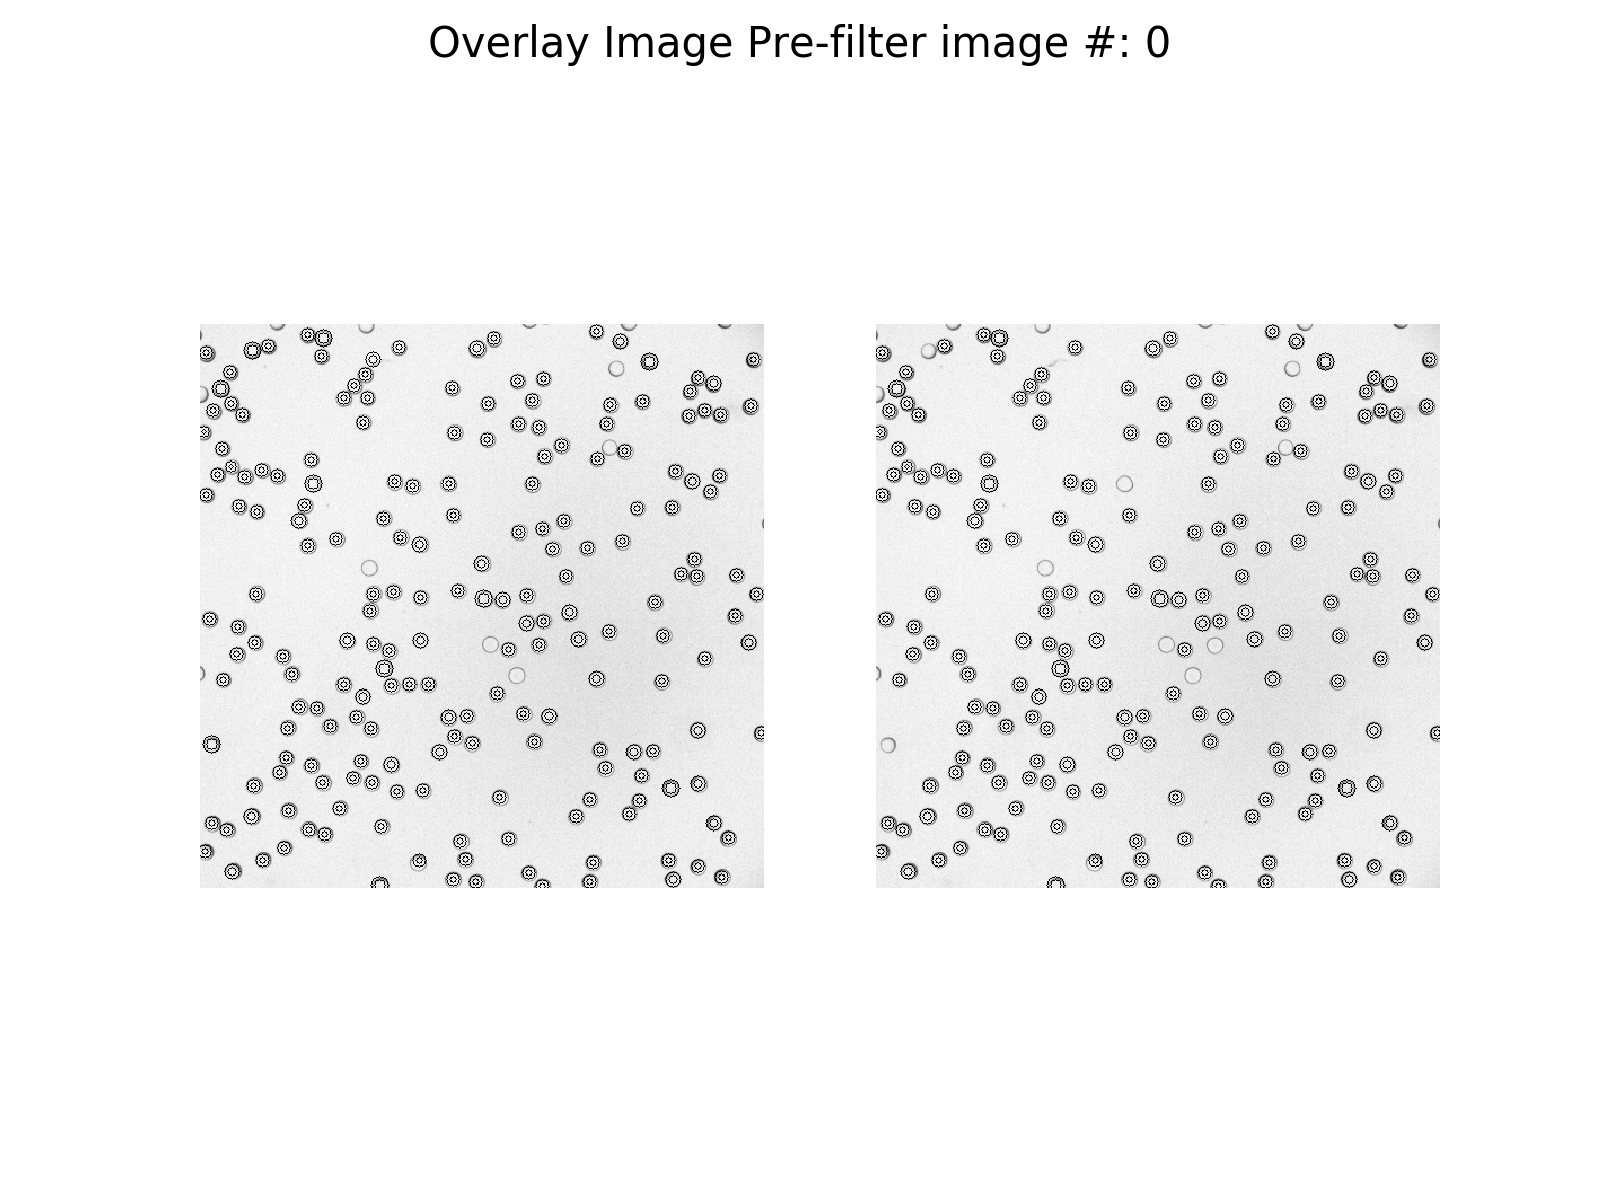

<IPython.core.display.Javascript object>


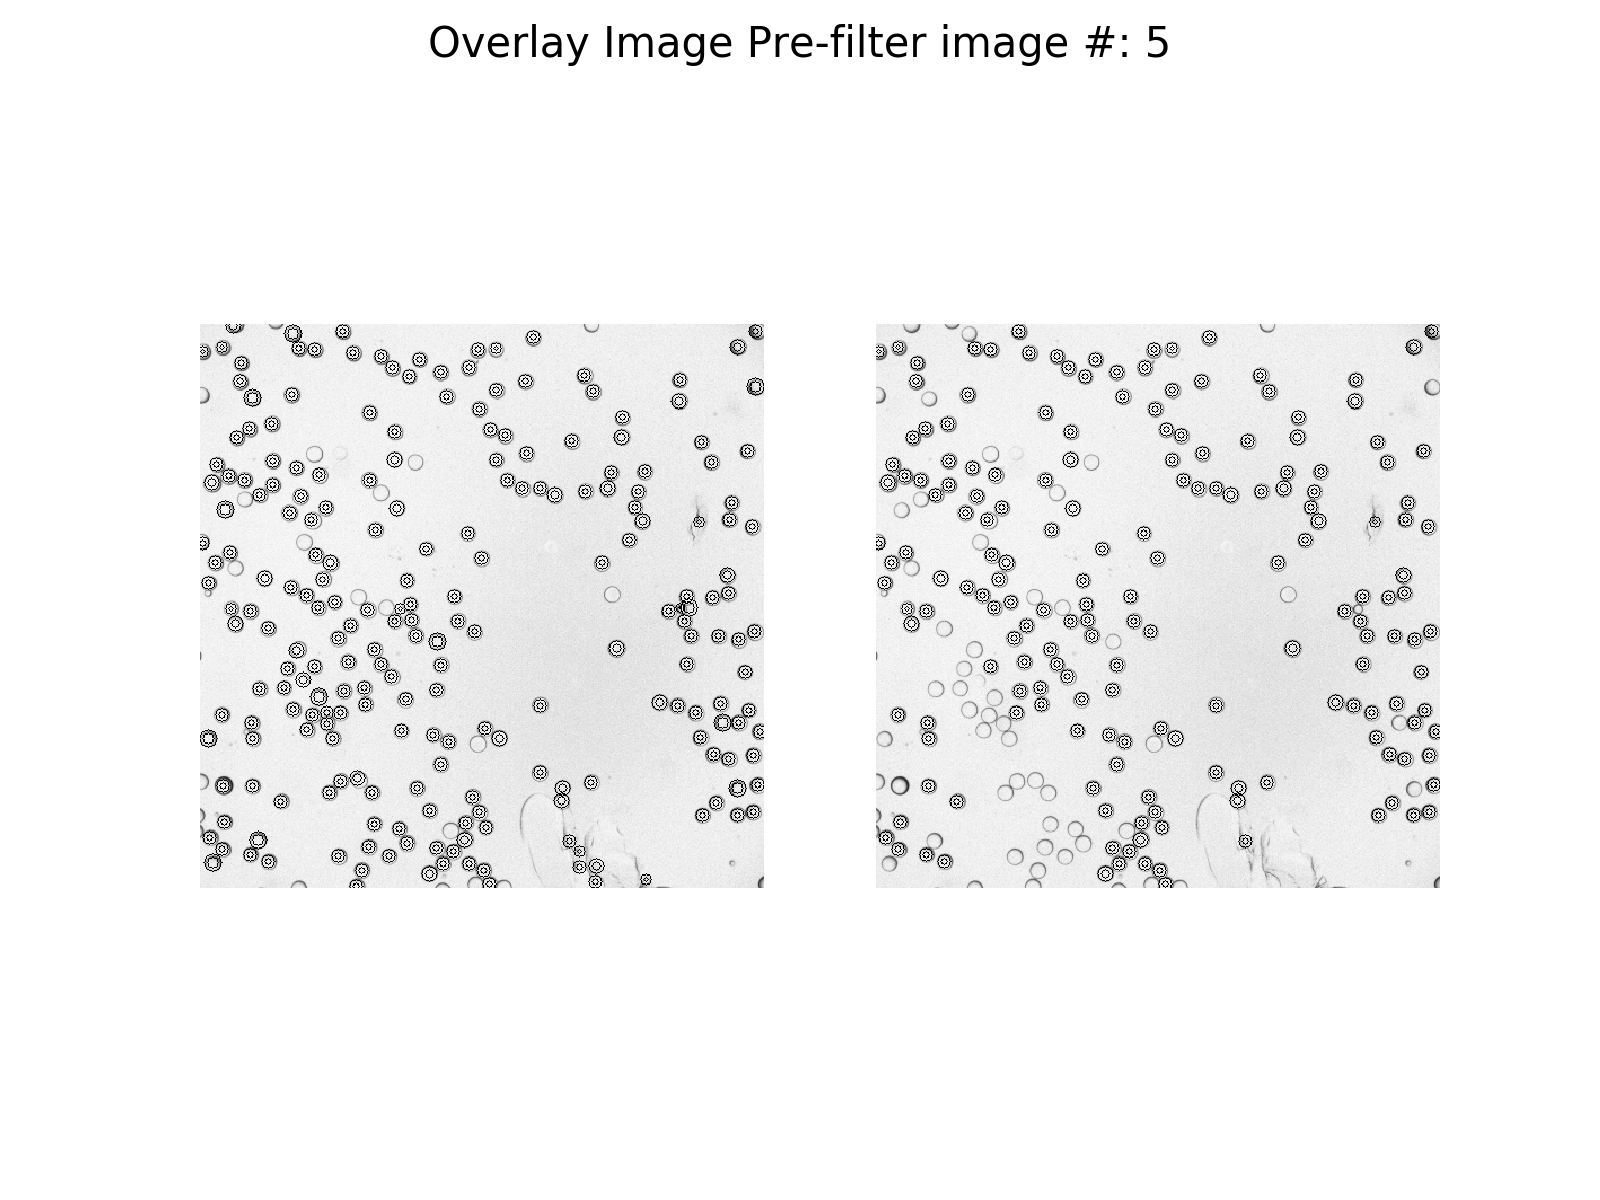

<IPython.core.display.Javascript object>


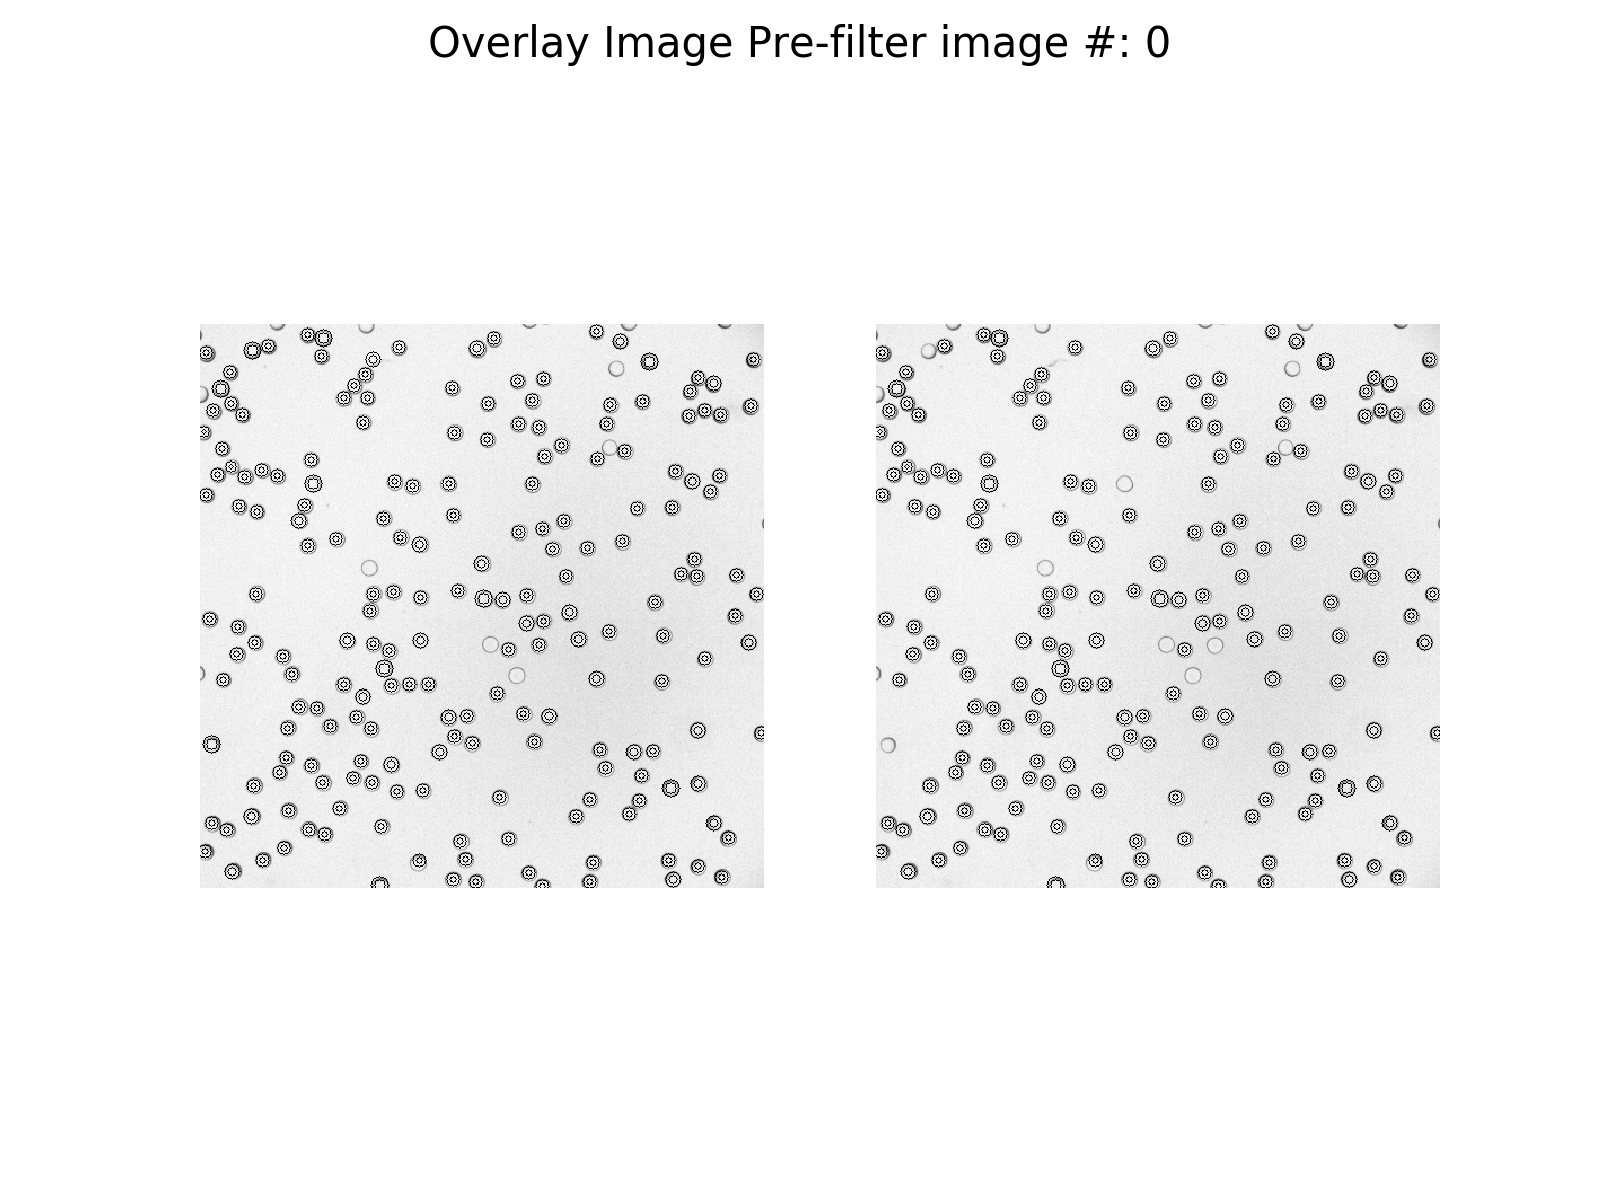

In [8]:
mask_bkg    = ( (bead_set.bkg > (bead_set.bkg.mean() - back_std_factor * bead_set.bkg.std())) &\
                (bead_set.bkg < (bead_set.bkg.mean() + back_std_factor * bead_set.bkg.std())) )
mask_ref    = ( (bead_set.ref > (bead_set.ref.mean() - reference_std_factor_low * bead_set.ref.std())) &\
                (bead_set.ref < (bead_set.ref.mean() + reference_std_factor_high * bead_set.ref.std())) )
filter_all = (mask_bkg & mask_ref)

print("Pre filter: %s" % bead_set.index.size)
print("Post filter: %s" % bead_set[filter_all].index.size)

# Pre-filter images
img_idx = []
for x in xrange(3):
    idx = random.choice(np.unique(bead_set.img))
    img_idx.append(idx)
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.axis('off')
    fig.suptitle("Overlay Image Pre-filter image #: %s" % idx)
    ax.imshow(bead_objects.overlay_image(bead_image_set_bf[idx], 
                                          dim=bead_set.loc[(bead_set['img'] == idx), ('dim_x','dim_y','dim_r')].values,
                                          annulus=True), cmap='Greys_r')
    ax = fig.add_subplot(1,2,2)
    ax.axis('off')
    ax.imshow(bead_objects.overlay_image(bead_image_set_bf[idx], 
                                          dim=bead_set.loc[filter_all & (bead_set['img'] == idx), ('dim_x','dim_y','dim_r')].values,
                                          annulus=True), cmap='Greys_r')

# ICP

In [9]:
icp.fit(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')], target)
bead_set = bead_set.join(icp.transform())
print("Tranformation matrix: ", icp.matrix)
print("Offset vector: ", icp.offset)

Delta:  0.0545580284999
Delta:  0.0111768239016
Delta:  0.00159006519678
Delta:  0.0
Converged after: 4
Tranformation matrix:  [[ 0.89088947  0.01791836 -0.01658786]
 [-0.01134549  0.92981781 -0.07595778]
 [-0.23982026 -0.07924066  6.24136686]]
Offset vector:  [-0.01069119 -0.00430936 -0.01030323]


# Classification

In [10]:
gmix.decode(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')])
bead_set = bead_set.join(gmix.output)
print("Number of unique codes found:", gmix.found)
print("Missing codes:", gmix.missing)

Number of unique codes found: 48
Missing codes: None


## Data inspection charts
Notes...

<IPython.core.display.Javascript object>


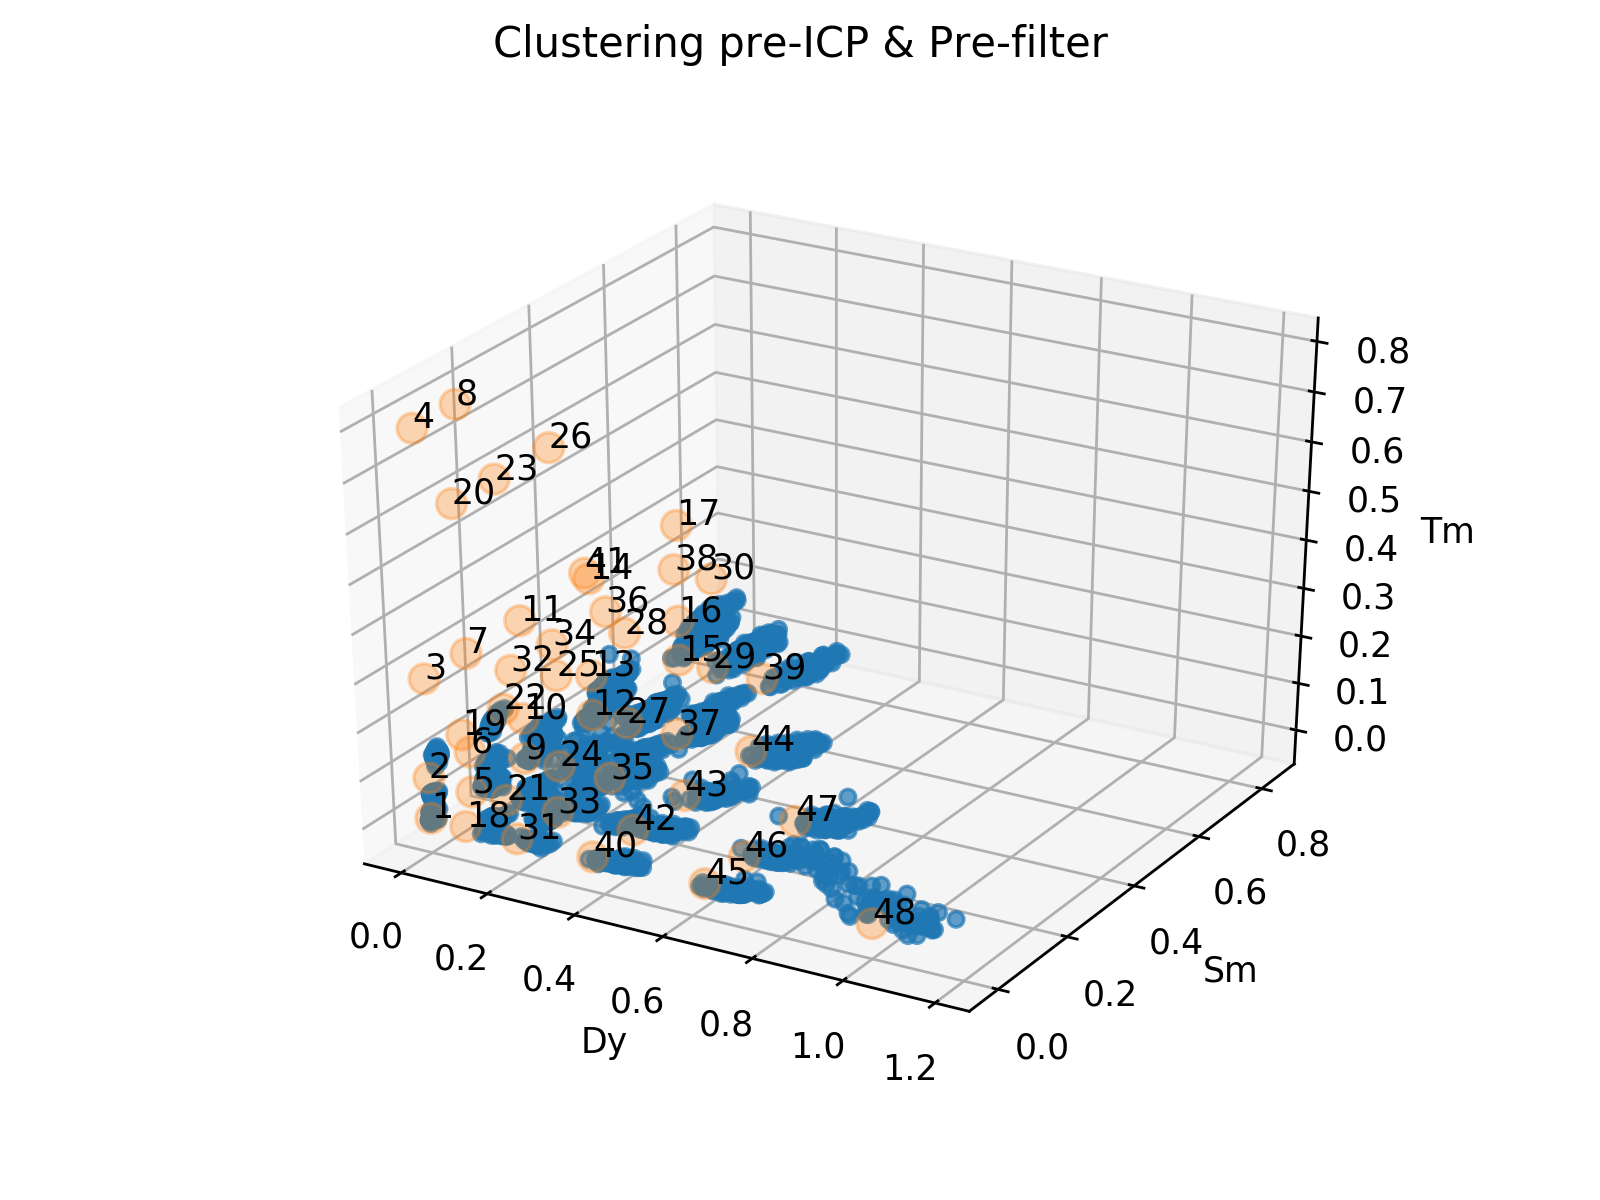

<IPython.core.display.Javascript object>


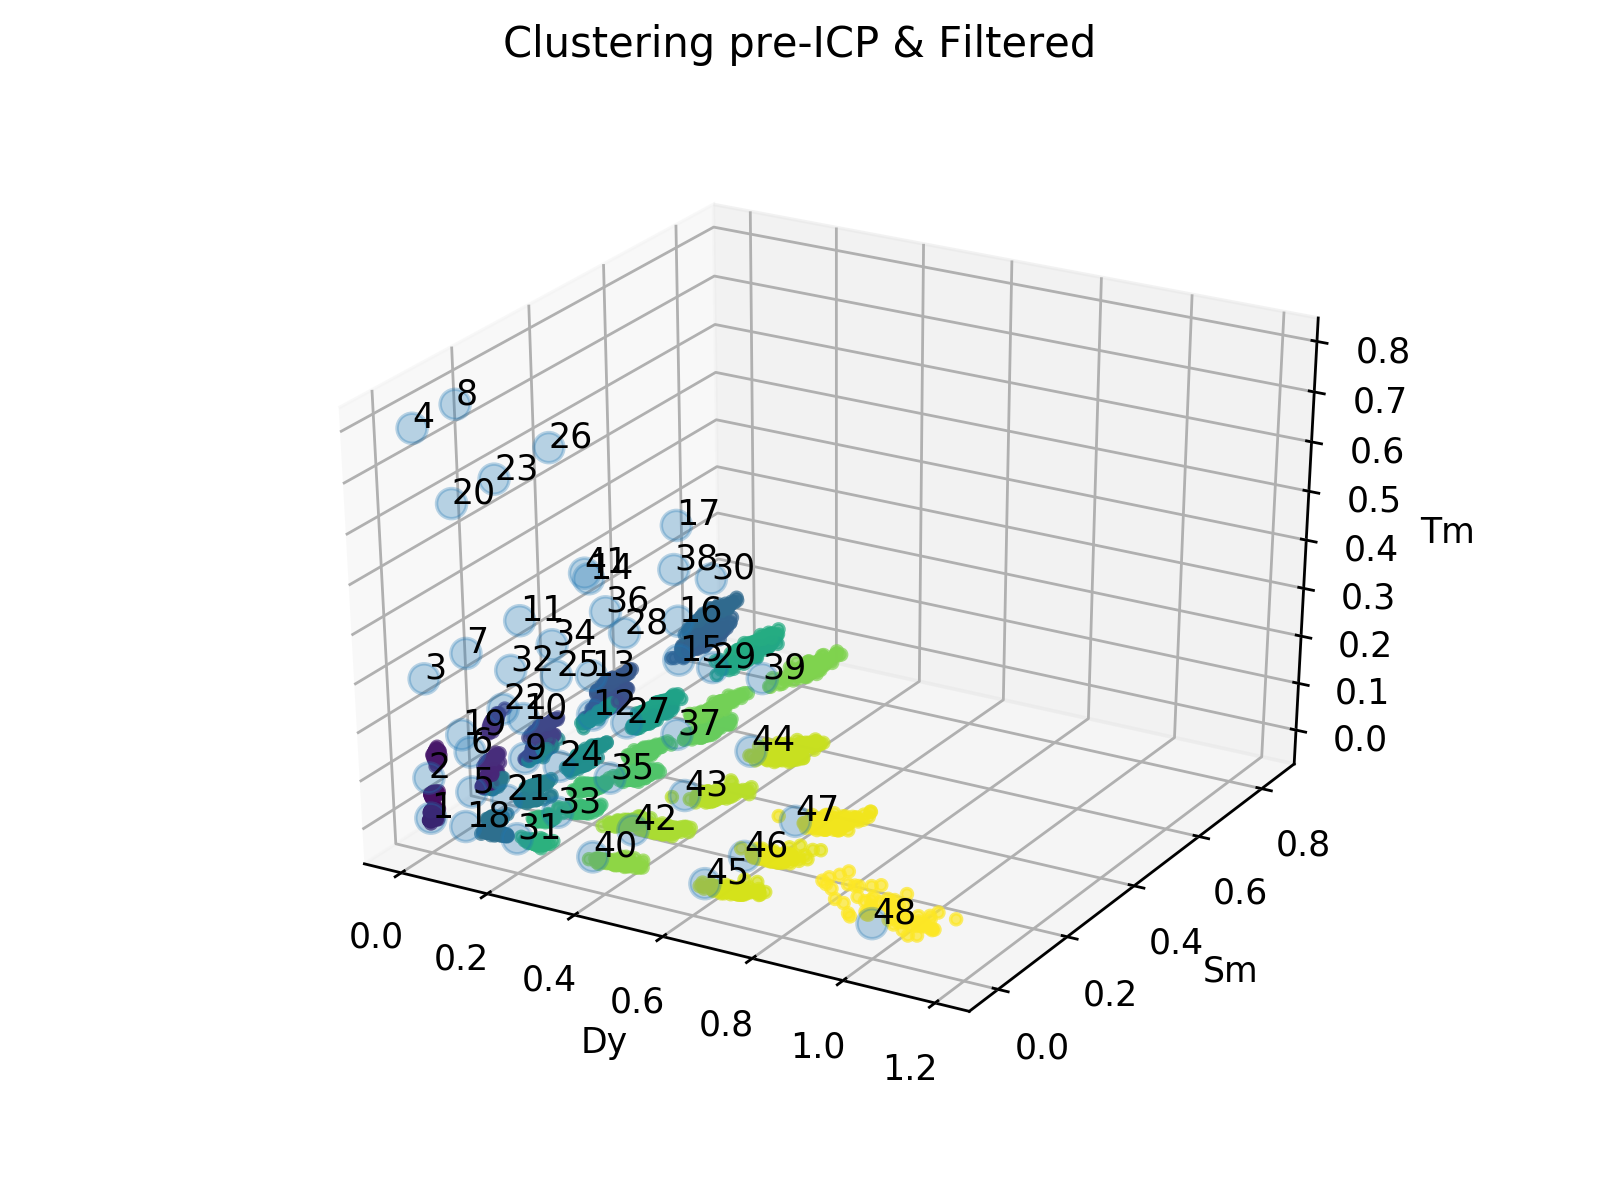

<IPython.core.display.Javascript object>


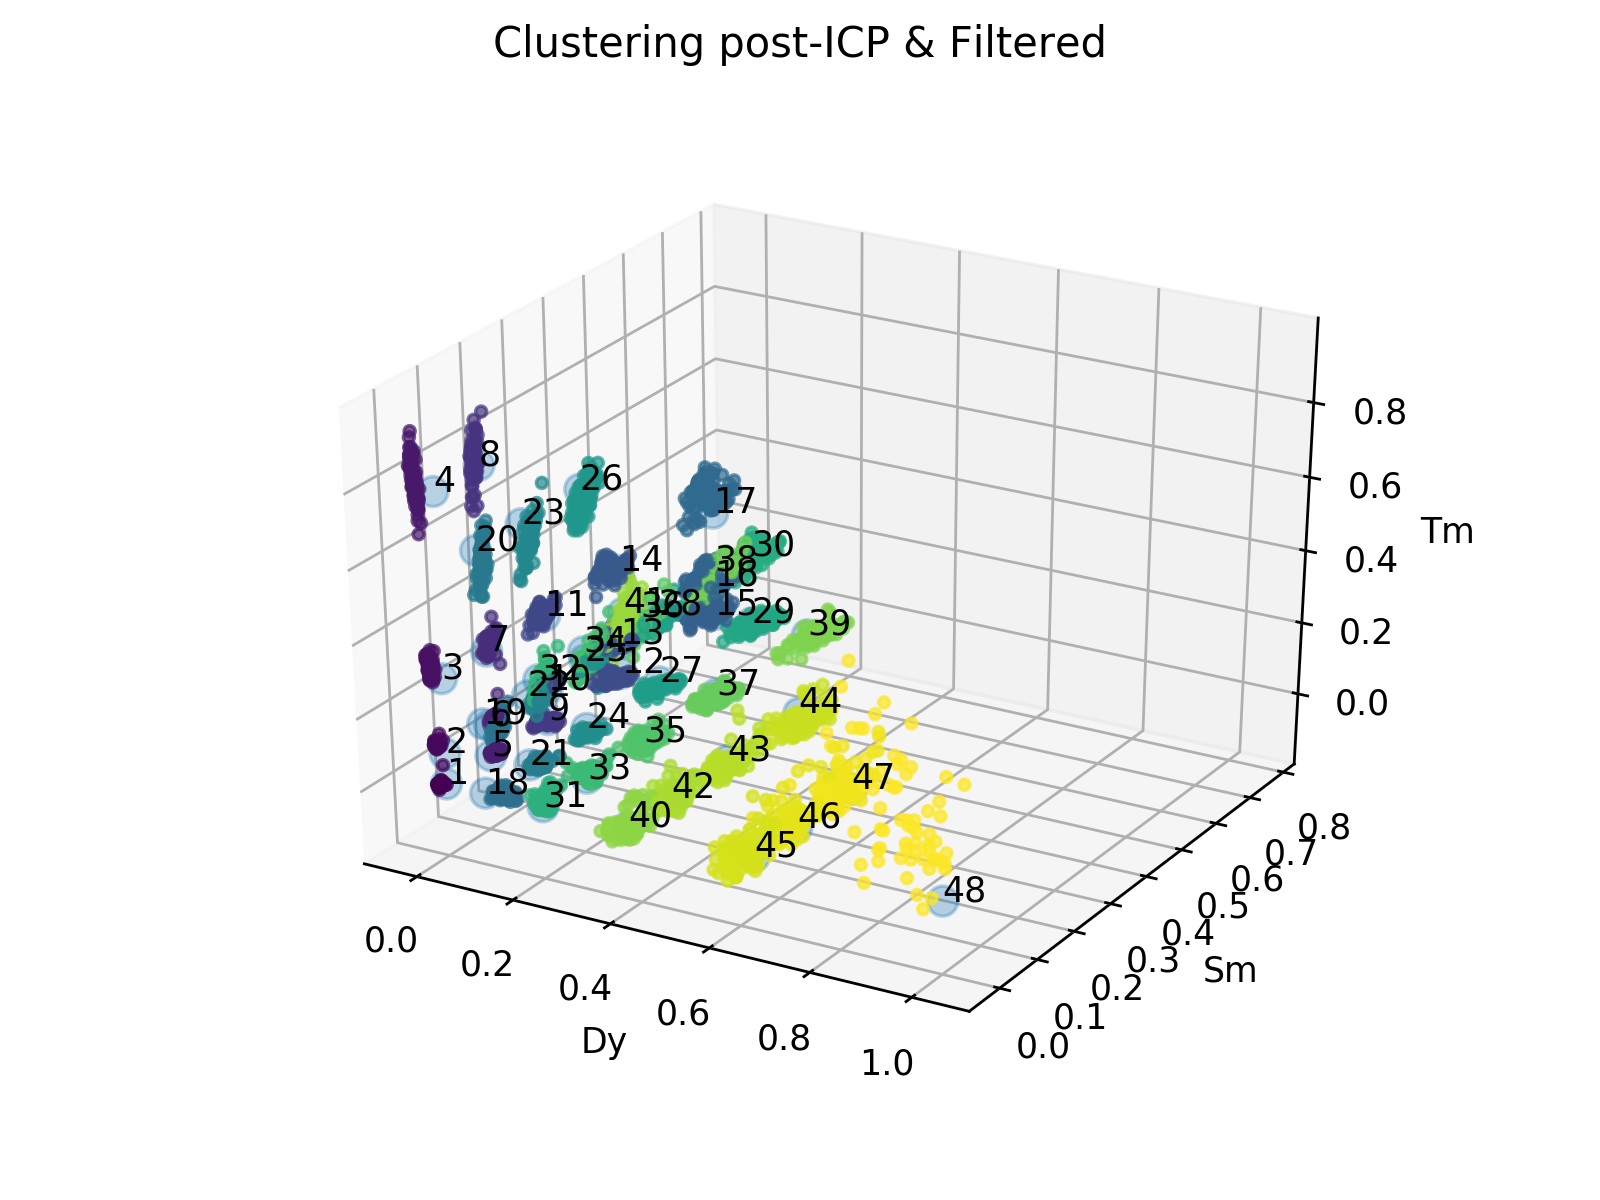

<IPython.core.display.Javascript object>


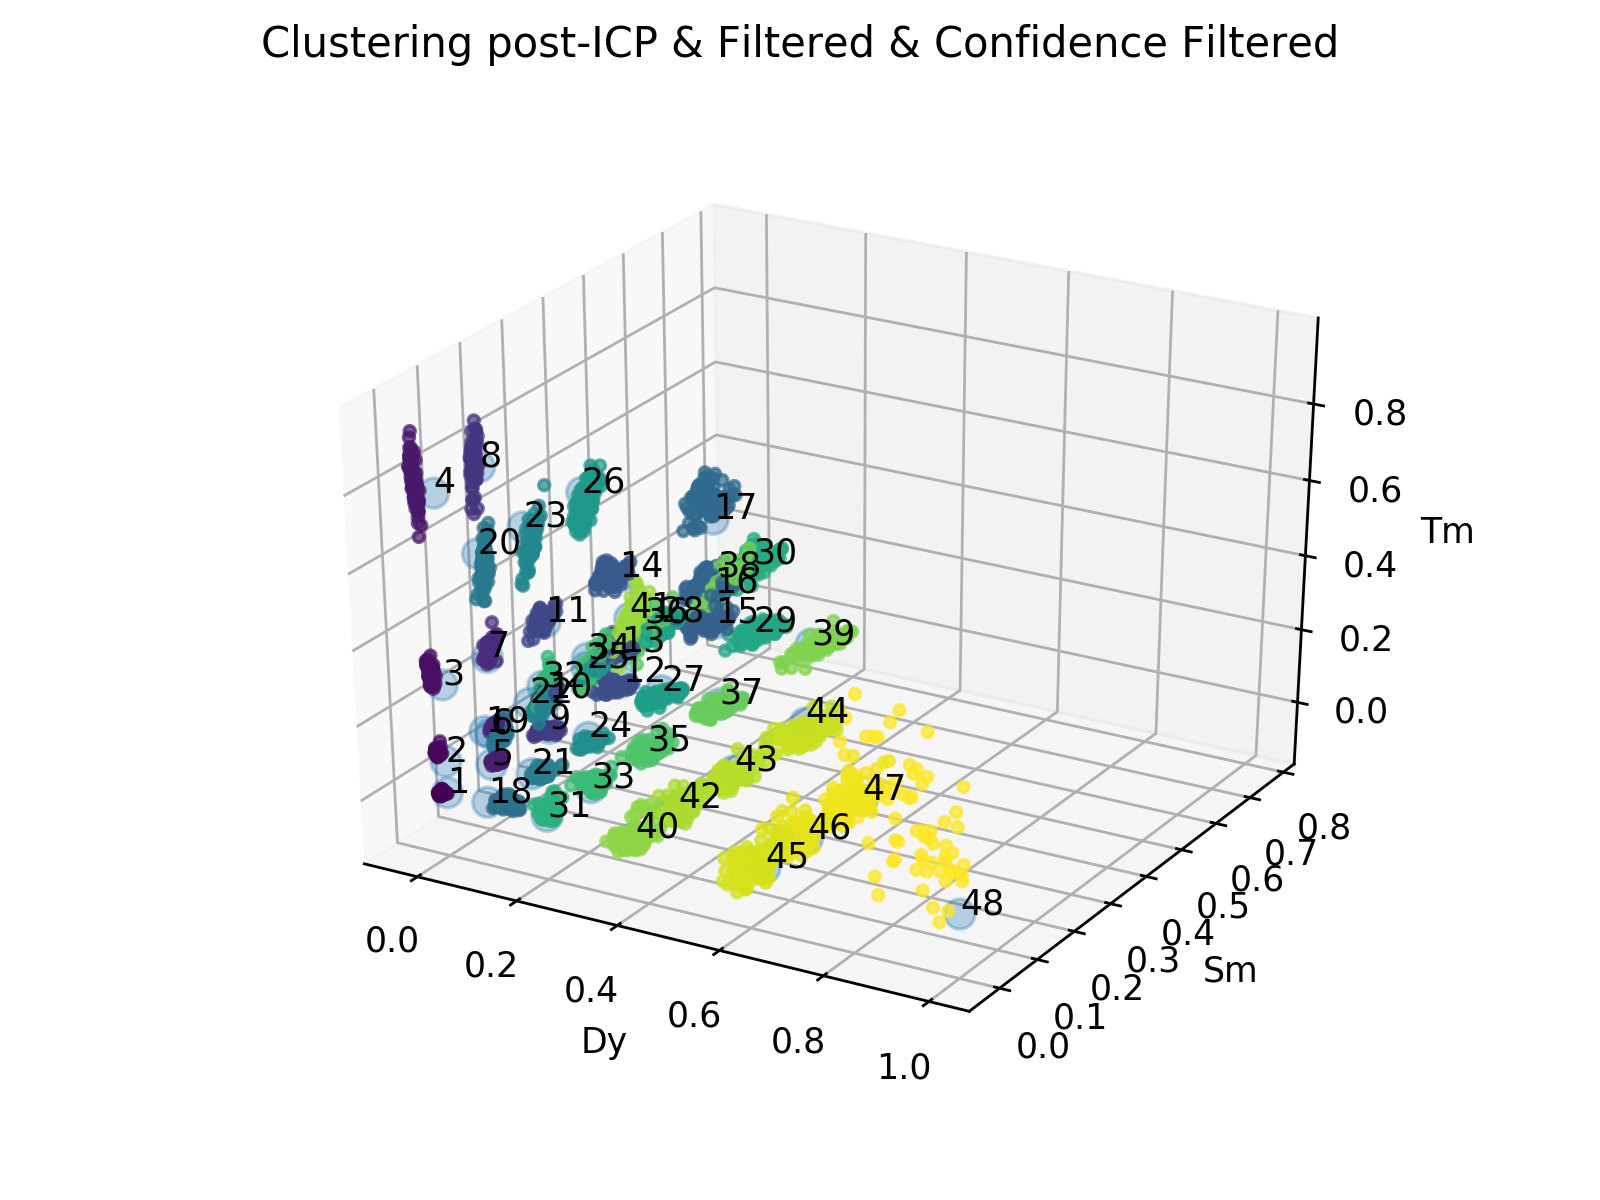

<IPython.core.display.Javascript object>


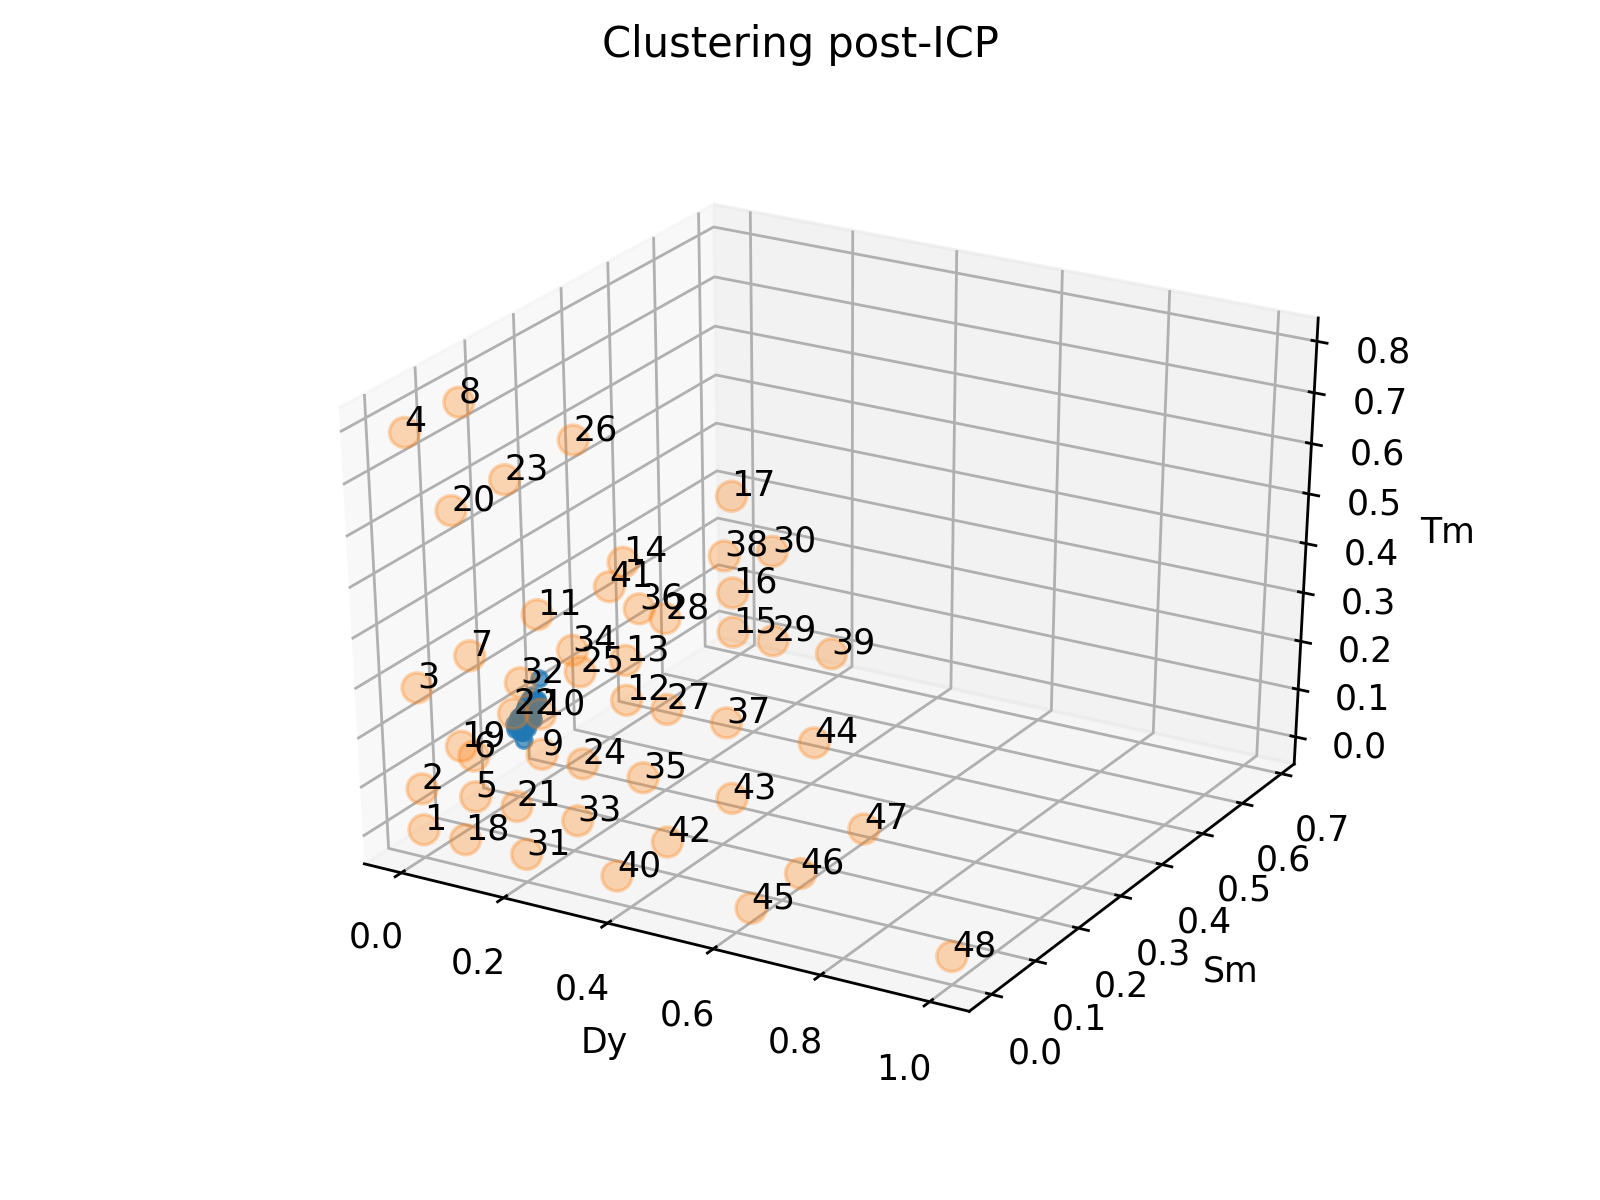

<IPython.core.display.Javascript object>


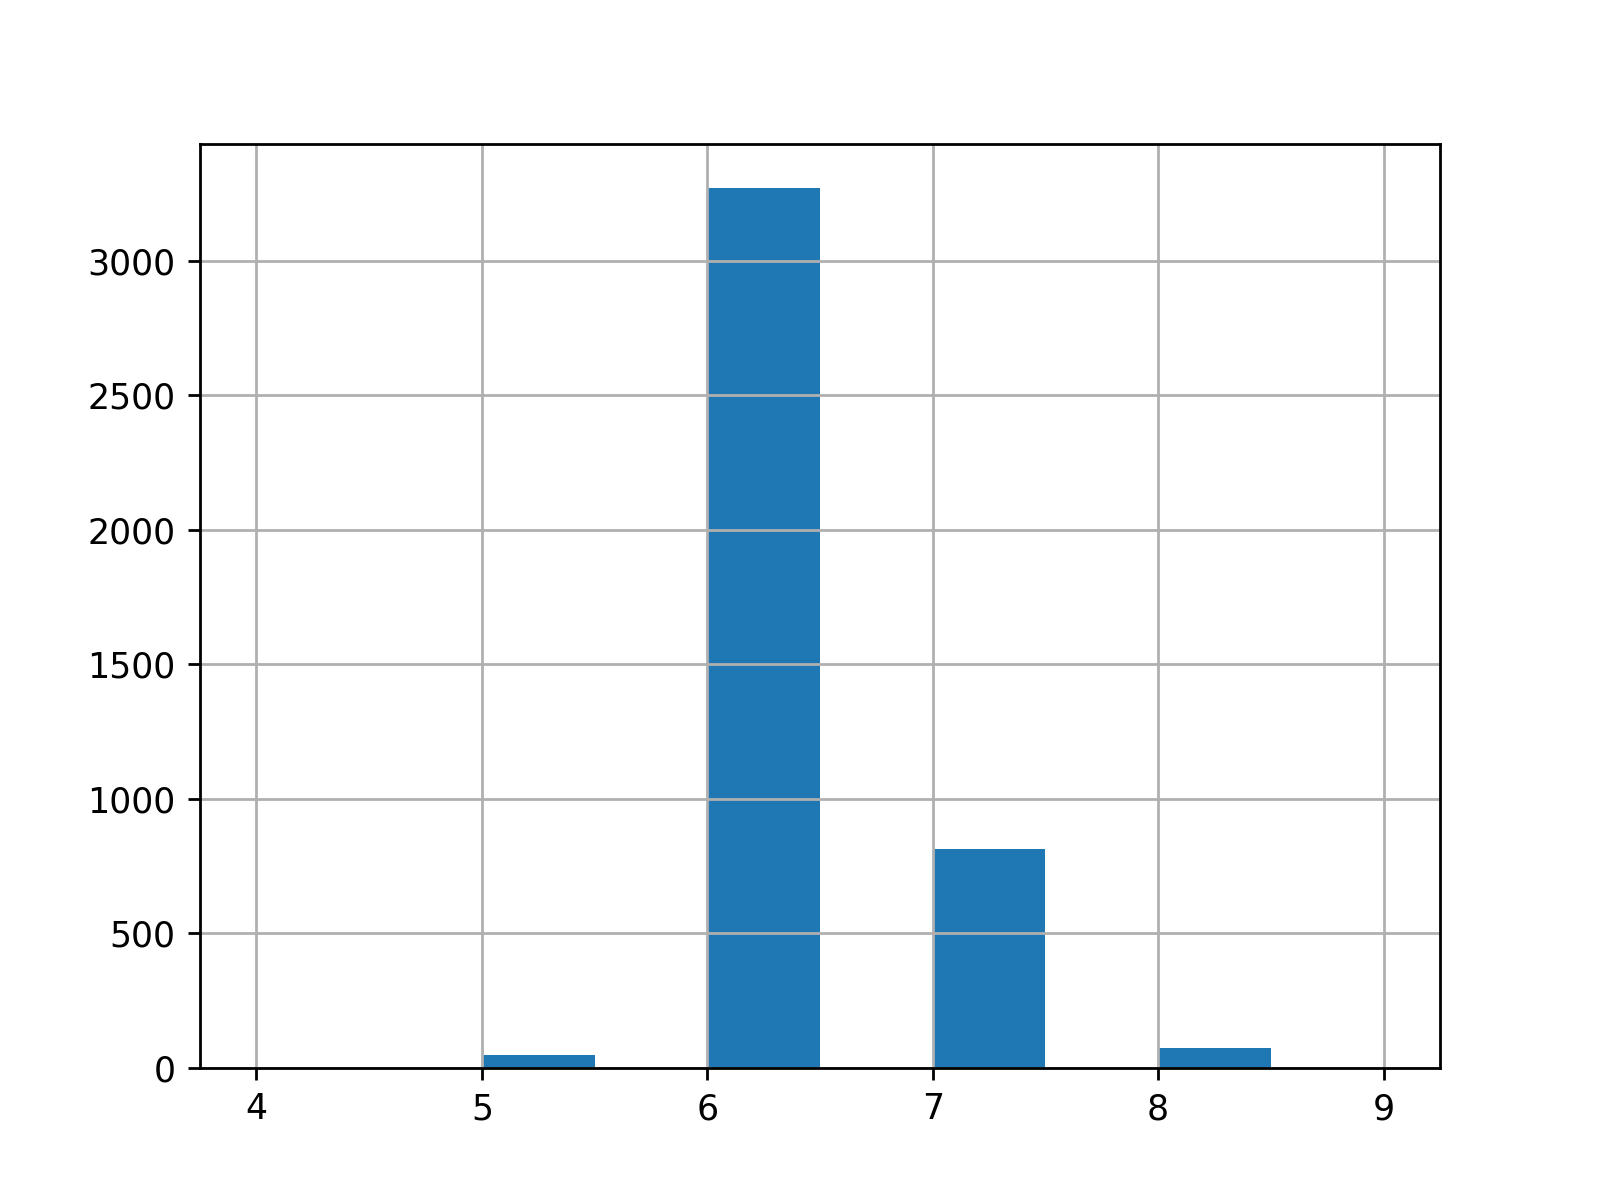

<IPython.core.display.Javascript object>


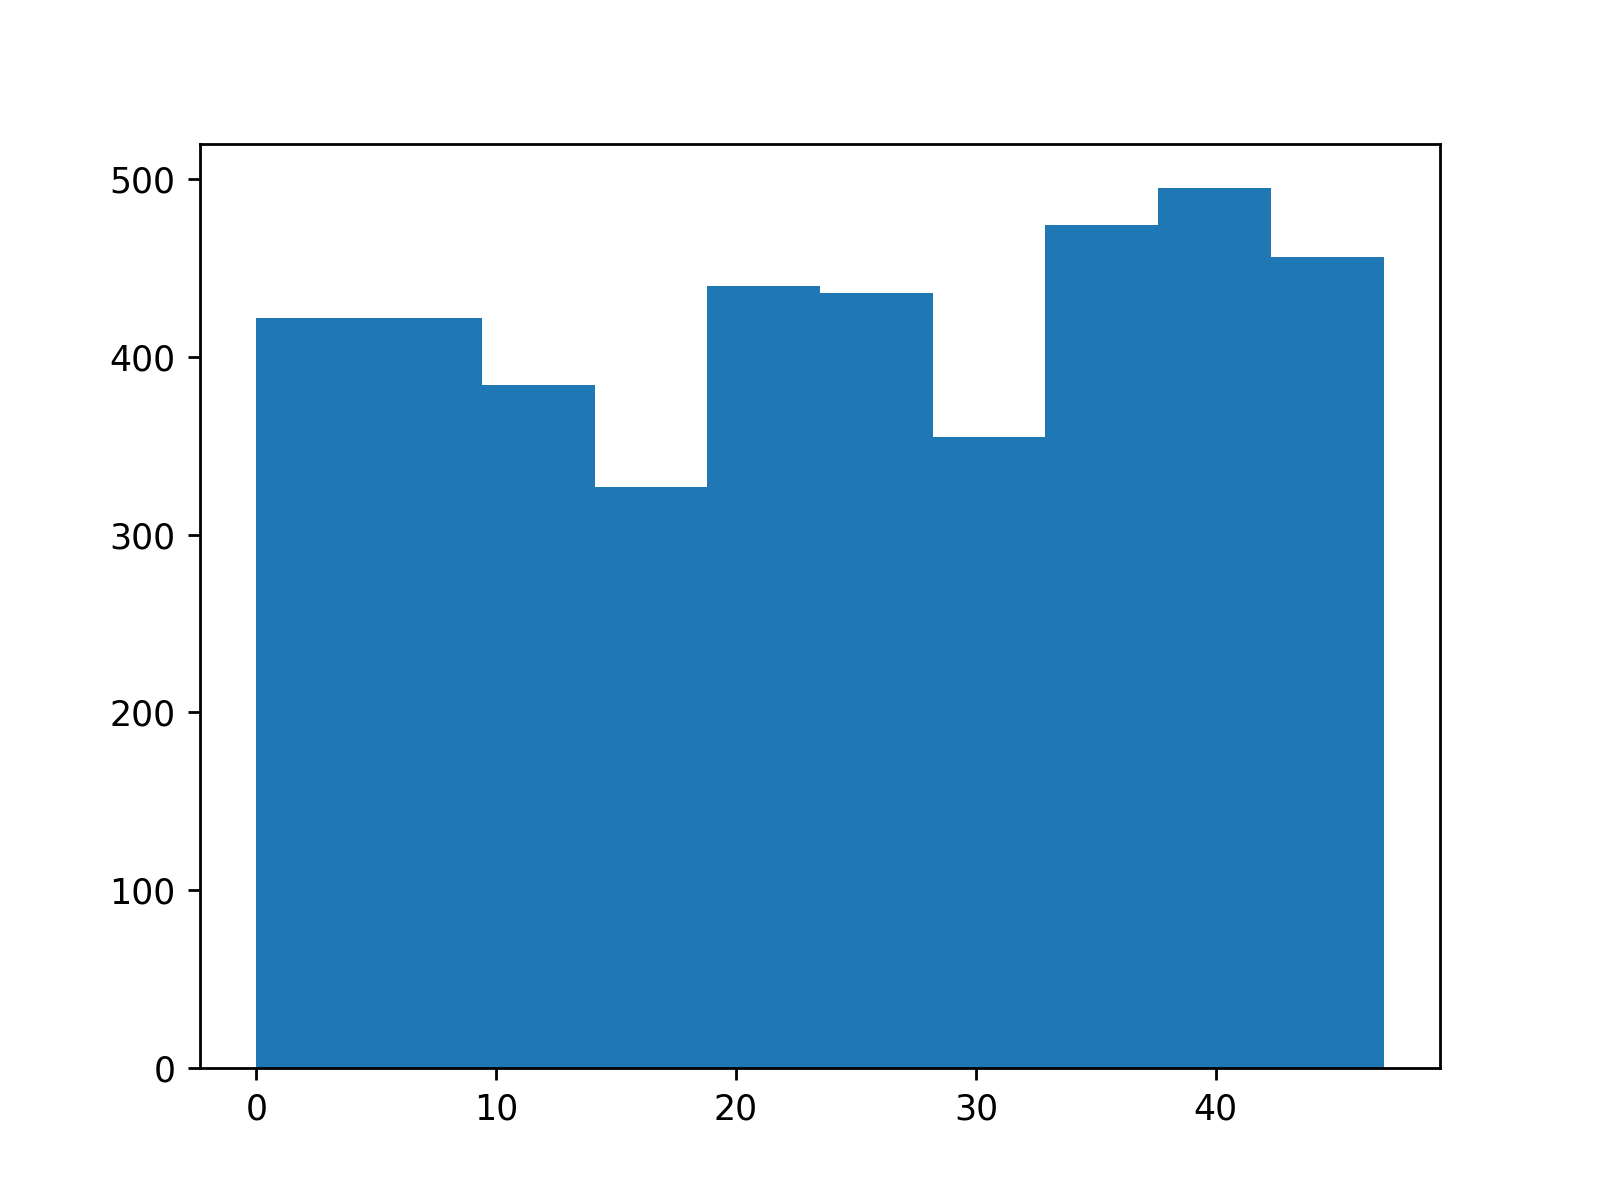

(array([ 422.,  422.,  384.,  327.,  440.,  436.,  355.,  474.,  495.,  456.]),
 array([  0. ,   4.7,   9.4,  14.1,  18.8,  23.5,  28.2,  32.9,  37.6,
         42.3,  47. ]),
 <a list of 10 Patch objects>)

In [11]:
# Clustering pre-ICP & Pre-filter
ba.inspect.Cluster.scatter(bead_set.loc[:, ('rat_dy', 'rat_sm', 'rat_tm')].values, 
                           target, 
                           title="Clustering pre-ICP & Pre-filter", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering pre-ICP & Filtered
ba.inspect.Cluster.scatter(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')].values, 
                           target, 
                           bead_set.loc[filter_all, ('code')].values, 
                           title="Clustering pre-ICP & Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering post-ICP & Filtered
ba.inspect.Cluster.scatter(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].values, 
                           target, 
                           bead_set.loc[filter_all, ('code')].values, 
                           title="Clustering post-ICP & Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering post-ICP & Filtered & Confidence Filtered
ba.inspect.Cluster.scatter(bead_set.loc[(bead_set.confidence > 0), ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].values, 
                           target, 
                           bead_set.loc[(bead_set.confidence > 0), ('code')].values, 
                           title="Clustering post-ICP & Filtered & Confidence Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])

# Single code chart
code_no = 21 # Starts at 0!
code_data = np.vstack(bead_set.loc[(bead_set.code == code_no), ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].as_matrix())
ba.inspect.Cluster.scatter(code_data, target, title="Clustering post-ICP", axes_names=['Dy', 'Sm', 'Tm'])

# Size dist
plt.figure()
bead_set.loc[filter_all, ('dim_r')].hist(bins=10)

# Beads per code distribution
plt.figure()
plt.hist(bead_set.loc[filter_all, ('code')])

## Scatter charts

In [12]:
confidence = 0
colors = np.multiply(bead_set.code.loc[(bead_set.confidence > confidence)].values, np.ceil(255/gmix._nclusters))

bead_ratios = go.Scatter3d(
    name='Bead ratios',
    x=bead_set.loc[(bead_set.confidence > confidence), ('rat_dy_icp')].values,
    y=bead_set.loc[(bead_set.confidence > confidence), ('rat_sm_icp')].values,
    z=bead_set.loc[(bead_set.confidence > confidence), ('rat_tm_icp')].values,
    text=bead_set.loc[(bead_set.confidence > confidence), ('code')].values,
    mode='markers',
    marker=dict(
        size=3,
        color=colors, 
        colorscale='Rainbow',
        opacity=0.6
    )
)

target_ratios = go.Scatter3d(
    name='Target ratios',
    x=target[:,0],
    y=target[:,1],
    z=target[:,2],
    text=range(gmix._nclusters),
    mode='markers',
    marker=dict(
        size=4,
        color='Black',
        opacity=0.5,
        symbol="diamond"
    )
)

mean_ratios = go.Scatter3d(
    name='GMM mean ratios',
    x=gmix.means[:,0],
    y=gmix.means[:,1],
    z=gmix.means[:,2],
    text=range(gmix._nclusters),
    mode='markers',
    marker=dict(
        size=4,
        color='Red',
        opacity=0.5,
        symbol="diamond"
    )
)

data = [bead_ratios, target_ratios, mean_ratios]
layout = go.Layout(
    showlegend=True,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')